In [1]:
import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scipy.io import loadmat
import hypyp
import mne
import numpy as np

from data_analysis.functions_connectivity import \
    plot_connectivity_matrix
from data_analysis.functions_behavioral import \
    (create_event_df, remove_ghost_triggers, calculate_alpha,
     join_event_dfs, remove_outliers, events_from_event_df)

import matplotlib.pyplot as plt

result_dir = "/net/store/nbp/projects/hyperscanning/study_project/results/"

In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /net/store/nbp/projects/hyperscanning/study_project

In [2]:
subj = 212
cond = "early"
ispcs = loadmat(op.join(result_dir, "ispc_matrices", str(subj) + "_" + cond + ".mat"))[cond]

#mne.viz.plot_

In [3]:
ispcs[0, :, :, 0].shape

(128, 128)

In [4]:
tfr = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", str(subj) + "_" + cond))[0]

Reading /net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/212_early ...


<ipython-input-4-f30baabdb29c>:1: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/212_early) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  tfr = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", str(subj) + "_" + cond))[0]


Not setting metadata


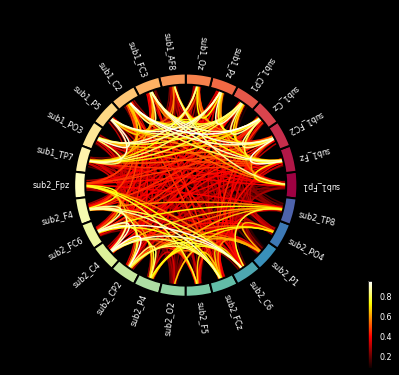

(<Figure size 576x576 with 2 Axes>, <PolarAxesSubplot:>)

In [5]:
mne.viz.plot_connectivity_circle(ispcs[0, ::5, ::5, 0], node_names=tfr.ch_names[::5])

In [6]:
avg_ispcs = np.mean(ispcs, axis=0)

/net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/functions_connectivity.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(reversed(node_names))
/net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/functions_connectivity.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(node_names)


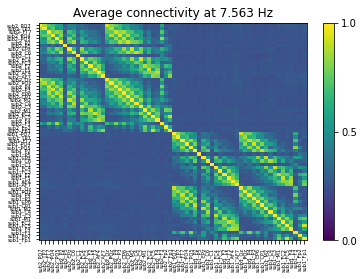

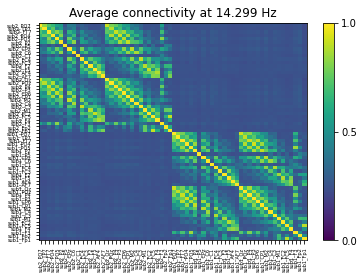

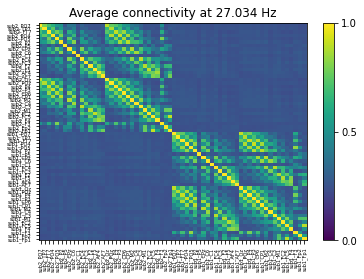

In [7]:
freq_i = 5
plot_connectivity_matrix(avg_ispcs[::2, ::2, freq_i], node_names=tfr.ch_names[::2],
                         title="Average connectivity at {} Hz".format(np.round(tfr.freqs[freq_i], 3)))

freq_i = 10
plot_connectivity_matrix(avg_ispcs[::2, ::2, freq_i], node_names=tfr.ch_names[::2],
                         title="Average connectivity at {} Hz".format(np.round(tfr.freqs[freq_i], 3)))

freq_i = 15
plot_connectivity_matrix(avg_ispcs[::2, ::2, freq_i], node_names=tfr.ch_names[::2],
                         title="Average connectivity at {} Hz".format(np.round(tfr.freqs[freq_i], 3)))

Intra vs Inter brain bar plots

In [8]:
inter_b = [np.mean(avg_ispcs[0:64, 64:2*64, i]) for i in range(len(tfr.freqs))]
intra_b = [np.mean(avg_ispcs[0:64, 0:64, i]) for i in range(len(tfr.freqs))]

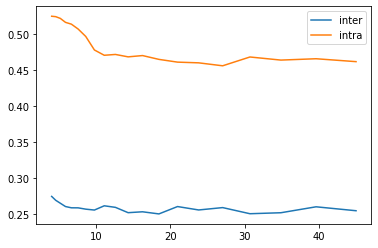

In [9]:
plt.plot(tfr.freqs, inter_b, tfr.freqs, intra_b)
plt.legend(["inter", "intra"])

#todo: bin frequencies and make a bar plot of data

## load and plot the Small world indices

Text(0, 0.5, 'SWI')

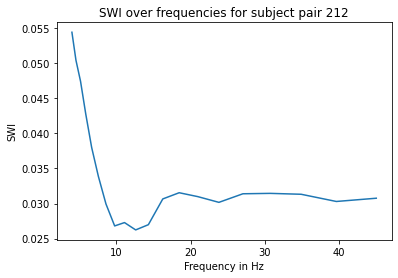

In [10]:
swis = loadmat(op.join(result_dir, "small_worlds", str(subj) + "_" + cond + ".mat"))[cond]

avg_swis = np.mean(swis, axis=0)

plt.plot(tfr.freqs, avg_swis)
plt.title("SWI over frequencies for subject pair {}".format(subj))
plt.xlabel("Frequency in Hz")
plt.ylabel("SWI")

## load the behavioral data and bad trials (which were filtered by autoreject)

In [11]:
import pandas


behav_path = "/net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"


In [41]:
# do the behavioral analysis and get the epochs
df = pandas.read_csv(op.join(behav_path, str(subj) + ".csv"))
df = calculate_alpha(df)

# load the swis
swis = loadmat(op.join(result_dir, "small_worlds", str(subj) + "_" + cond + ".mat"))[cond]

# remove all the trials that were removed by autoreject
bad_trials = loadmat(op.join(result_dir, "dropped_epochs", str(subj) + ".mat"))["drop_list"][0]
double_taps = loadmat(op.join(result_dir, "double_taps", str(subj) + ".mat"))["double_taps"][0]

# remove the epochs marked as bad from autoreject
df = df[np.logical_not(df["trial"].isin(bad_trials + 1))]

# add the positive trial indices to remove double taps
trial_n = np.array([i for i in range(300) if i not in bad_trials]) + 1

# remove the epochs marked as bad from double taps
df = df[np.logical_not(df["trial"].isin(double_taps))]
swis = np.array([vals for trial, vals in zip(trial_n, swis) if trial not in double_taps])

print(len(swis), len(set(df["trial"])))


87 87


In [58]:
# get the average alpha for early
early_start = df.groupby(["trial"])["ttap"].min()
early_stop = early_start + 1.5

early_avg = []
for start, stop in zip(early_start, early_stop):
    df_filt = df[np.logical_and(df["ttap"] >= start, df["ttap"] <= stop)]
    early_avg.append(df_filt["alpha_lin"].mean())
print(early_avg)

# get the average alpha for late
# same for old
late_stop = df.groupby(["trial"])["ttap"].max()
late_start = late_stop - 1.5

late_avg = []
for start, stop in zip(late_start, late_stop):
    df_filt = df[np.logical_and(df["ttap"] >= start, df["ttap"] <= stop)]
    late_avg.append(df_filt["alpha_lin"].mean())
print(late_avg)

[79.2291308917364, 63.38042724550196, 77.91668466506131, 71.71117472704992, 58.26586837844536, 50.074279728147445, 71.24893023038649, 58.89084347622256, 51.978431227436786, 55.33534128447267, 63.943519801171334, 54.46193833745052, 81.10554602038022, 72.19681714547242, 68.32682463462726, 77.46414436109016, 61.43443685602319, 79.5001154083617, 72.79488747328473, 70.10467264492878, 80.97283568800579, 50.928896862328514, 59.77145231923587, 66.02145670429957, 64.68118613646307, 76.57381483411993, 59.62830085884202, 52.21446382520804, 73.84098718201909, 69.63294713573542, 61.1166356011779, 57.077851666257565, 60.88588347894426, 65.14393653665437, 66.15561790241482, 78.01805794469918, 71.12861022958118, 75.16833518491984, 53.502229330693766, 54.23232229438688, 70.11475158776106, 57.94514924435815, 75.85173551196996, 56.42169722630714, 57.17455961443772, 57.44580912773205, 65.73230912123923, 72.6136709985103, 67.19986306658328, 74.82910229339129, 71.52937721490832, 57.62560314170268, 70.761120

In [65]:
rs = []
for freq in range(swis.shape[-1]):
    r = np.corrcoef(swis[:, freq], early_avg)
    #plt.scatter(swis[:, freq], early_avg)
    #plt.show()
    rs.append(r[0, 1])
rs

[-0.06985957598082626,
 -0.1010873956565718,
 -0.12490126532517466,
 -0.002506766615139784,
 -0.027267349018548003,
 0.06724114490355826,
 -0.03894402878430572,
 -0.05380615031152338,
 0.06867057733647457,
 0.09458899886654908,
 0.032329328890306666,
 0.07552409884014316,
 -0.024927823170291002,
 0.1308326410295541,
 0.11935962642968288,
 -0.07974180750477187,
 0.03006987522215465,
 -0.12140536388017645,
 0.0054907759206384845,
 0.16482752048551325]

In [64]:
#np.corrcoef(np.mean(swis, axis=-1), early_avg)

np.corrcoef(np.mean(swis, axis=-1), late_avg)

array([[ 1., nan],
       [nan, nan]])

[[ 1. nan]
 [nan nan]]


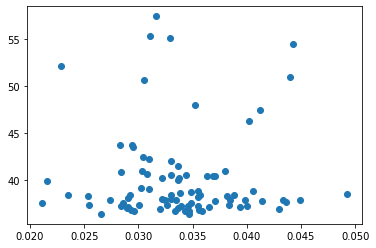

In [61]:
plt.scatter(np.mean(swis, axis=-1), late_avg)
print(np.corrcoef(np.mean(swis, axis=-1), late_avg))

In [ ]:
min_idx = event_df.groupby(["trial"])["sample"].idxmin()
early_df = event_df[event_df.index.isin(min_idx)]
early_events = events_from_event_df(early_df)
early_events[:,-1] = 1

# get the late taps by looking at the last sample - 1.5 seconds
max_idx = event_df.groupby(["trial"])["sample"].idxmax()
late_df = event_df[event_df.index.isin(max_idx)]